In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from collections import Counter

import sklearn
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
df_all = pd.read_csv('sp500_joined_closes.csv', index_col=0)
df_all.fillna(0,inplace=True)
df = pd.concat([df_all['AAPL'],df_all['NFLX'],df_all['FB'],df_all['AMZN'],df_all['ORCL']],axis=1)

,AAPL,NFLX,FB,AMZN,ORCL
Date,,,,,
2010-01-04,27.847252,7.640000,0.0,133.899994,22.900264
2010-01-05,27.895396,7.358572,0.0,134.690002,22.872617
2010-01-06,27.451683,7.617143,0.0,132.250000,22.540862
2010-01-07,27.400936,7.485714,0.0,130.000000,22.467139
2010-01-08,27.583106,7.614286,0.0,133.520004,22.743602


              AAPL         NFLX           FB         AMZN         ORCL
count  1777.000000  1777.000000  1777.000000  1777.000000  1777.000000
mean     75.694248    49.731662    47.178447   341.791188    32.939592
std      28.853798    36.060470    43.836229   192.987400     6.218249
min      24.989789     7.018571     0.000000   108.610001    19.854186
25%      50.605461    16.972857     0.000000   193.729996    28.244324
50%      73.560156    38.058571    32.230000   285.880005    32.366365
75%     102.603209    79.668571    80.779999   404.390015    38.734071
max     128.520900   140.110001   133.279999   844.359985    44.721152


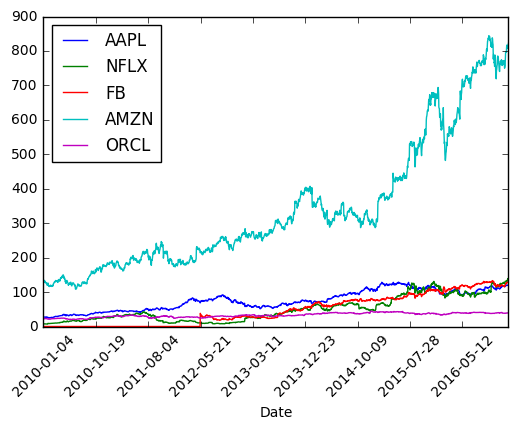

,AAPL,NFLX,FB,AMZN,ORCL
AAPL,1.000000,0.786467,0.873409,0.771957,0.861623
NFLX,0.786467,1.000000,0.918614,0.914078,0.779563
FB,0.873409,0.918614,1.000000,0.933552,0.852518
AMZN,0.771957,0.914078,0.933552,1.000000,0.729872
ORCL,0.861623,0.779563,0.852518,0.729872,1.000000


In [3]:
def Explore_SP500(df):
    display(df.head())
    print(df.describe())
    df.plot()
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.show()
    display(df.corr())

Explore_SP500(df)

In [4]:
hm_days=8
def process_data_for_labels(ticker,df,hm_days):
 
    tickers = df.columns.values
    df.fillna(0, inplace=True)

    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i)-df[ticker])/df[ticker]
        
    df.fillna(0, inplace=True)
    
    return tickers, df

In [5]:
## if there is more than 2% drop, sell it.  If there is more than 2% growth, but it!
#Otherwise, just keep kit
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

In [6]:
def extract_feature(ticker,df,hm_days):
    tickers, df = process_data_for_labels(ticker,df,hm_days)
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,*
                                              [df['{}_{}d'.format(ticker, i)]for i in range(1, hm_days+1)]))
    
    vals = df['{}_target'.format(ticker)].values
    str_vals = [str(i) for i in vals]
    print('Data Spread:', Counter(str_vals))
    df.fillna(0, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [7]:
def stock_classifier(ticker,df,hm_days):
    X, y, df = extract_feature(ticker,df,hm_days)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, 
                                    test_size=0.35, random_state=600)
    
    clf = svm.LinearSVC()
    clf = RandomForestClassifier(max_features='auto', min_samples_split=10, class_weight= 'balanced')
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    pred_score = clf.score(X_test, y_test)
    display(confusion_matrix(y_test,predictions))
    return 'pred_score_{}: {}'.format(ticker,pred_score)

In [8]:
stock_classifier('AAPL',df,hm_days)

Data Spread: Counter({'1': 814, '-1': 731, '0': 232})
Predicted spread: Counter({1: 296, -1: 254, 0: 72})


array([[113,  31, 123],
       [ 31,   9,  36],
       [110,  32, 137]])

'pred_score_AAPL: 0.41639871382636656'

In [9]:
stock_classifier('NFLX',df,hm_days)

Data Spread: Counter({'1': 979, '-1': 741, '0': 57})
Predicted spread: Counter({1: 378, -1: 240, 0: 4})


array([[112,   0, 149],
       [  6,   0,  13],
       [122,   4, 216]])

'pred_score_NFLX: 0.5273311897106109'

In [10]:
stock_classifier('FB',df,hm_days)

Data Spread: Counter({'0': 694, '1': 614, '-1': 469})
Predicted spread: Counter({0: 256, 1: 213, -1: 151})


array([[ 64,  15,  78],
       [ 10, 219,  15],
       [ 77,  22, 120]])

'pred_score_FB: 0.65'

In [11]:
stock_classifier('AMZN',df,hm_days)

Data Spread: Counter({'1': 940, '-1': 681, '0': 156})
Predicted spread: Counter({1: 385, -1: 216, 0: 19})


array([[ 96,   8, 138],
       [ 23,   4,  24],
       [ 97,   7, 223]])

'pred_score_AMZN: 0.5209677419354839'

In [12]:
stock_classifier('ORCL',df,hm_days)

Data Spread: Counter({'1': 763, '-1': 627, '0': 387})
Predicted spread: Counter({1: 322, -1: 207, 0: 91})


array([[ 91,  32, 113],
       [ 29,  22,  75],
       [ 87,  37, 134]])

'pred_score_ORCL: 0.39838709677419354'